# 🚀 Stella Model QLoRA Fine-tuning for Fake Review Classification

This notebook demonstrates how to fine-tune the `NovaSearch/stella_en_400M_v5` model using QLoRA (Quantized Low-Rank Adaptation) for fake review classification. The implementation uses 4-bit quantization to enable efficient training on consumer GPUs.

## Key Features:
- **4-bit Quantization**: Reduces memory usage by ~75%
- **LoRA Adaptation**: Efficient fine-tuning with minimal parameters
- **Proper Target Modules**: Uses correct `qkv_proj` and `o_proj` layers
- **GPU Optimized**: Designed for 6-8GB VRAM GPUs

---

In [10]:
! pip install --upgrade transformers accelerate peft bitsandbytes

## 1. Import Required Libraries

Import all necessary libraries for data processing, model training, and evaluation.

In [1]:
# ==============================================================================
# IMPORT LIBRARIES
# ==============================================================================
import os
import sys
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from datasets import Dataset
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig,
)
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput

print("✅ All libraries imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🤗 Transformers available")
print(f"⚡ PEFT available")

c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully!
🔥 PyTorch version: 2.7.1+cu118
🤗 Transformers available
⚡ PEFT available


## 2. Configuration and Hyperparameters

Define all configuration parameters including model settings, LoRA parameters, and training hyperparameters.

In [3]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODEL_NAME = "NovaSearch/stella_en_400M_v5"
DATASET_PATH = "dataset/cleaned_dataset.csv"
OUTPUT_DIR = "./stella_qlora_finetuned_model"

# LoRA Configuration
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05

### --- CRITICAL FIX BASED ON MODEL INSPECTION --- ###
# The Stella model uses fused Query-Key-Value layers ("qkv_proj")
# and an output projection layer ("o_proj"). These are the correct
# module names for LoRA adaptation.
LORA_TARGET_MODULES = ["qkv_proj", "o_proj"]

# Training Configuration
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 8
LEARNING_RATE = 2e-4
NUM_EPOCHS = 3
MAX_SEQ_LENGTH = 512

print("⚙️ Configuration Summary:")
print(f"   📋 Model: {MODEL_NAME}")
print(f"   📁 Dataset: {DATASET_PATH}")
print(f"   🎯 Target Modules: {LORA_TARGET_MODULES}")
print(f"   🔧 LoRA r={LORA_R}, alpha={LORA_ALPHA}, dropout={LORA_DROPOUT}")
print(f"   📊 Batch Size: {BATCH_SIZE} (effective: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS})")
print(f"   📚 Learning Rate: {LEARNING_RATE}")
print(f"   🔄 Epochs: {NUM_EPOCHS}")

⚙️ Configuration Summary:
   📋 Model: NovaSearch/stella_en_400M_v5
   📁 Dataset: dataset/cleaned_dataset.csv
   🎯 Target Modules: ['qkv_proj', 'o_proj']
   🔧 LoRA r=16, alpha=32, dropout=0.05
   📊 Batch Size: 2 (effective: 16)
   📚 Learning Rate: 0.0002
   🔄 Epochs: 3


## 3. Environment Setup and GPU Configuration

Check GPU availability and configure the environment for optimal performance.

In [4]:
# ==============================================================================
# ENVIRONMENT SETUP
# ==============================================================================
def setup_environment():
    """Setup and validate the training environment."""
    if not torch.cuda.is_available():
        print("❌ No GPU detected. QLoRA requires a GPU for efficient training.")
        print("💡 Please ensure you have a CUDA-compatible GPU and PyTorch with CUDA support.")
        return None, None
    
    device = torch.device("cuda")
    has_bf16_support = torch.cuda.is_bf16_supported()
    
    print(f"✅ GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"🔥 BFloat16 Support: {'Yes' if has_bf16_support else 'No (will use Float16)'}")
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    return device, has_bf16_support

# Setup environment
device, has_bf16_support = setup_environment()

if device is None:
    print("\n⚠️ Cannot proceed without GPU. Please check your setup.")
else:
    print(f"\n🚀 Environment ready! Using device: {device}")

✅ GPU detected: NVIDIA GeForce RTX 4050 Laptop GPU
💾 GPU Memory: 6.4 GB
🔥 BFloat16 Support: Yes

🚀 Environment ready! Using device: cuda


## 4. Custom Model Definition

Define a custom Stella model class for sequence classification with proper handling of quantization and attention mechanisms.

In [5]:
# ==============================================================================
# CUSTOM MODEL DEFINITION
# ==============================================================================
class StellaForSequenceClassification(torch.nn.Module):
    """Custom Stella model wrapper for sequence classification."""
    
    def __init__(self, model_name, num_labels, quantization_config):
        super(StellaForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        
        # Configure the model to disable memory efficient attention
        # This prevents xformers compatibility issues
        config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        config.use_memory_efficient_attention = False
        config.unpad_inputs = False
        
        # Load the base Stella model
        self.stella = AutoModel.from_pretrained(
            model_name,
            config=config,
            trust_remote_code=True,
            quantization_config=quantization_config,
            device_map="auto"
        )
        
        self.config = self.stella.config
        
        # Add classification head
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.config.hidden_size, num_labels)
        
        print(f"✅ Stella model loaded with {num_labels} labels")
        print(f"📐 Hidden size: {self.config.hidden_size}")

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        """Forward pass with proper pooling and classification."""
        # Get embeddings from Stella
        outputs = self.stella(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        
        # Apply attention-weighted pooling
        masked_hidden_state = last_hidden_state * attention_mask.unsqueeze(-1)
        pooled_output = masked_hidden_state.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)
        
        # Classification
        logits = self.classifier(self.dropout(pooled_output))
        
        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return SequenceClassifierOutput(loss=loss, logits=logits)

print("✅ Custom StellaForSequenceClassification class defined successfully!")

✅ Custom StellaForSequenceClassification class defined successfully!


## 5. Data Loading and Preprocessing

Load the dataset and create train/validation/test splits with proper preprocessing.

In [6]:
# ==============================================================================
# DATA LOADING AND PREPROCESSING
# ==============================================================================
def load_and_prepare_data(dataset_path):
    """Load dataset and create train/validation/test splits."""
    print(f"\n📂 Loading dataset from '{dataset_path}'...")
    
    try:
        df = pd.read_csv(dataset_path)
        print(f"✅ Dataset loaded successfully! Shape: {df.shape}")
    except FileNotFoundError:
        print(f"❌ Dataset not found! Please check the path: {dataset_path}")
        return None, None, None
    
    # Clean and prepare data
    df_clean = df[['text', 'label']].copy().dropna()
    print(f"🧹 Cleaned dataset shape: {df_clean.shape}")
    
    # Check label distribution
    label_counts = df_clean['label'].value_counts()
    print(f"📊 Label distribution:")
    for label, count in label_counts.items():
        print(f"   Label {label}: {count} samples ({count/len(df_clean)*100:.1f}%)")
    
    # Create stratified splits
    train_val_df, test_df = train_test_split(
        df_clean, test_size=0.2, random_state=42, stratify=df_clean['label']
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=0.1, random_state=42, stratify=train_val_df['label']
    )
    
    print("\n📈 Data splits created:")
    print(f"   🚂 Training:   {len(train_df):,} samples")
    print(f"   🔍 Validation: {len(val_df):,} samples")
    print(f"   🧪 Test:       {len(test_df):,} samples")
    
    # Convert to HuggingFace datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)
    
    return train_dataset, val_dataset, test_dataset

# Load the data
train_dataset, val_dataset, test_dataset = load_and_prepare_data(DATASET_PATH)

if train_dataset is not None:
    print("\n🎯 Data loading completed successfully!")
    print(f"Sample text: {train_dataset[0]['text'][:100]}...")
    print(f"Sample label: {train_dataset[0]['label']}")
else:
    print("❌ Failed to load data. Please check your dataset path.")


📂 Loading dataset from 'dataset/cleaned_dataset.csv'...
✅ Dataset loaded successfully! Shape: (40432, 4)
🧹 Cleaned dataset shape: (40432, 2)
📊 Label distribution:
   Label 1: 20216 samples (50.0%)
   Label 0: 20216 samples (50.0%)

📈 Data splits created:
   🚂 Training:   29,110 samples
   🔍 Validation: 3,235 samples
   🧪 Test:       8,087 samples

🎯 Data loading completed successfully!
Sample text: The quality of this lace is very nice. It is very comfortable and my son loves it.Great quality and ...
Sample label: 1


## 6. Model and Tokenizer Setup

Load the Stella model with quantization and prepare the tokenizer.

In [7]:
# ==============================================================================
# MODEL AND TOKENIZER SETUP
# ==============================================================================
if device is not None and train_dataset is not None:
    print("\n⚙️ Configuring QLoRA for 4-bit quantization...")
    
    # Setup quantization configuration
    compute_dtype = torch.bfloat16 if has_bf16_support else torch.float16
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
    )
    
    print(f"🔧 Quantization config:")
    print(f"   - 4-bit: True")
    print(f"   - Quant type: nf4")
    print(f"   - Compute dtype: {compute_dtype}")
    print(f"   - Double quantization: True")
    
    # Load model
    print(f"\n🚀 Loading base model '{MODEL_NAME}' with 4-bit quantization...")
    model = StellaForSequenceClassification(MODEL_NAME, 2, quantization_config)
    
    # Load tokenizer
    print(f"\n📝 Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    # Ensure tokenizer has a pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        print("✅ Set pad_token to eos_token")
    
    print(f"✅ Tokenizer loaded successfully!")
    print(f"📏 Vocab size: {len(tokenizer)}")
    print(f"🔤 Pad token: {tokenizer.pad_token}")
    
else:
    print("⚠️ Skipping model setup due to missing requirements.")


⚙️ Configuring QLoRA for 4-bit quantization...
🔧 Quantization config:
   - 4-bit: True
   - Quant type: nf4
   - Compute dtype: torch.bfloat16
   - Double quantization: True

🚀 Loading base model 'NovaSearch/stella_en_400M_v5' with 4-bit quantization...


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.8.0+cu128 with CUDA 1208 (you have 2.7.1+cu118)
    Python  3.9.13 (you have 3.13.3)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
Some weights of the model checkpoint at NovaSearch/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

✅ Stella model loaded with 2 labels
📐 Hidden size: 1024

📝 Loading tokenizer...
✅ Tokenizer loaded successfully!
📏 Vocab size: 30522
🔤 Pad token: [PAD]
✅ Tokenizer loaded successfully!
📏 Vocab size: 30522
🔤 Pad token: [PAD]


## 7. LoRA Configuration and Application

Apply LoRA adapters to the model with the correct target modules.

In [8]:
# ==============================================================================
# LORA CONFIGURATION AND APPLICATION
# ==============================================================================
if 'model' in locals() and model is not None:
    print("\n✨ Applying LoRA adapters to the model...")
    
    # Prepare model for k-bit training
    model = prepare_model_for_kbit_training(model)
    print("✅ Model prepared for k-bit training")
    
    # Configure LoRA
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=LORA_TARGET_MODULES,
        bias="none",
        inference_mode=False,
    )
    
    print(f"🎯 LoRA Configuration:")
    print(f"   - Task: {TaskType.SEQ_CLS}")
    print(f"   - Rank (r): {LORA_R}")
    print(f"   - Alpha: {LORA_ALPHA}")
    print(f"   - Dropout: {LORA_DROPOUT}")
    print(f"   - Target modules: {LORA_TARGET_MODULES}")
    
    # Apply LoRA
    try:
        model = get_peft_model(model, peft_config)
        print("\n🔥 LoRA applied successfully!")
        
        # Print trainable parameters
        print("\n📊 LoRA Model Configuration:")
        model.print_trainable_parameters()
        
    except Exception as e:
        print(f"❌ Error applying LoRA: {e}")
        print("💡 This might be due to incorrect target module names.")
        print("🔍 Please verify the target modules are correct for this model.")
        model = None
        
else:
    print("⚠️ Skipping LoRA setup due to missing model.")


✨ Applying LoRA adapters to the model...
✅ Model prepared for k-bit training
🎯 LoRA Configuration:
   - Task: TaskType.SEQ_CLS
   - Rank (r): 16
   - Alpha: 32
   - Dropout: 0.05
   - Target modules: ['qkv_proj', 'o_proj']

🔥 LoRA applied successfully!

📊 LoRA Model Configuration:
trainable params: 2,361,346 || all params: 436,502,532 || trainable%: 0.5410


## 8. Data Tokenization

Tokenize the datasets for training with proper padding and truncation.

In [9]:
# ==============================================================================
# DATA TOKENIZATION
# ==============================================================================
if 'tokenizer' in locals() and tokenizer is not None and train_dataset is not None:
    print("\n📝 Tokenizing datasets...")
    
    def tokenize_function(examples):
        """Tokenize text data with proper padding and truncation."""
        return tokenizer(
            examples["text"], 
            padding="max_length", 
            truncation=True, 
            max_length=MAX_SEQ_LENGTH
        )
    
    print(f"🔤 Tokenizing with max_length={MAX_SEQ_LENGTH}...")
    
    # Tokenize all datasets
    print("   - Tokenizing training set...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    
    print("   - Tokenizing validation set...")
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    
    print("   - Tokenizing test set...")
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
    
    print("\n✅ All datasets tokenized successfully!")
    
    # Show tokenization example
    sample = tokenized_train[0]
    print(f"\n📋 Tokenization example:")
    print(f"   Original text length: {len(sample['text'])} chars")
    print(f"   Tokenized length: {len(sample['input_ids'])} tokens")
    print(f"   Label: {sample['label']}")
    
else:
    print("⚠️ Skipping tokenization due to missing components.")


📝 Tokenizing datasets...
🔤 Tokenizing with max_length=512...
   - Tokenizing training set...


Map:   0%|          | 0/29110 [00:00<?, ? examples/s]

Map: 100%|██████████| 29110/29110 [00:04<00:00, 5851.96 examples/s]


   - Tokenizing validation set...


Map: 100%|██████████| 3235/3235 [00:00<00:00, 6281.64 examples/s]


   - Tokenizing test set...


Map: 100%|██████████| 8087/8087 [00:01<00:00, 6179.58 examples/s]


✅ All datasets tokenized successfully!

📋 Tokenization example:
   Original text length: 205 chars
   Tokenized length: 512 tokens
   Label: 1


## 9. Training Configuration

Set up the training arguments and evaluation metrics.

In [22]:
! pip install --upgrade transformers accelerate peft bitsandbytes

In [12]:
# ==============================================================================
# TRAINING CONFIGURATION
# ==============================================================================
def compute_metrics(eval_pred):
    """Compute evaluation metrics."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

if 'model' in locals() and model is not None:
    print("\n📋 Setting up Hugging Face Trainer...")
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- Step 6: Configure the Trainer (Modern Version) ---
    print("📋 Setting up Hugging Face Trainer...")

    # Configure training arguments with correct parameter names for current transformers version
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,  # Larger batch for evaluation
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        learning_rate=LEARNING_RATE,
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        optim="paged_adamw_8bit",
        fp16=not has_bf16_support,
        bf16=has_bf16_support,
        logging_dir=f"{OUTPUT_DIR}/logs",
        logging_steps=25,
        
        # Use correct parameter names for current transformers version
        eval_strategy="epoch",  # Changed from evaluation_strategy
        save_strategy="epoch",
        save_total_limit=2,
        
        # Load best model configuration
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        
        # Other configurations
        report_to="none",
        remove_unused_columns=True,
        dataloader_pin_memory=False,
        push_to_hub=False,
    )
    
    print("✅ Training arguments configured:")
    print(f"   📊 Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
    print(f"   📚 Learning rate: {LEARNING_RATE}")
    print(f"   🔄 Epochs: {NUM_EPOCHS}")
    print(f"   💾 Precision: {'BF16' if has_bf16_support else 'FP16'}")
    print(f"   🎯 Best model metric: F1 score")
    
else:
    print("⚠️ Skipping training configuration due to missing model.")


📋 Setting up Hugging Face Trainer...
📋 Setting up Hugging Face Trainer...
✅ Training arguments configured:
   📊 Effective batch size: 16
   📚 Learning rate: 0.0002
   🔄 Epochs: 3
   💾 Precision: BF16
   🎯 Best model metric: F1 score


## 10. Model Training

Initialize the trainer and start the fine-tuning process.

In [13]:
# ==============================================================================
# MODEL TRAINING
# ==============================================================================
if ('model' in locals() and model is not None and 
    'tokenized_train' in locals() and tokenized_train is not None):
    
    print("\n🚀 Initializing Trainer...")
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )
    
    print("✅ Trainer initialized successfully!")
    
    # Start training
    print("\n" + "="*60)
    print("🚀 STARTING QLORA FINE-TUNING")
    print("="*60)
    print(f"🎯 Model: {MODEL_NAME}")
    print(f"📊 Training samples: {len(tokenized_train):,}")
    print(f"🔍 Validation samples: {len(tokenized_val):,}")
    print(f"⚙️ LoRA target modules: {LORA_TARGET_MODULES}")
    print("="*60)
    print("\n🔥 Training in progress...")
    
    try:
        # Train the model
        train_result = trainer.train()
        
        print("\n" + "="*60)
        print("✅ TRAINING COMPLETED SUCCESSFULLY!")
        print("="*60)
        print(f"📊 Training results:")
        print(f"   - Final training loss: {train_result.training_loss:.4f}")
        print(f"   - Training steps: {train_result.global_step}")
        print(f"   - Training time: {train_result.metrics.get('train_runtime', 0):.2f} seconds")
        
        # Save the model
        print(f"\n💾 Saving model to: {OUTPUT_DIR}")
        trainer.save_model()
        print("✅ Model saved successfully!")
        
    except Exception as e:
        print(f"\n❌ Training failed with error: {e}")
        print("💡 This might be due to:")
        print("   - Insufficient GPU memory")
        print("   - Incompatible model/library versions")
        print("   - Target module configuration issues")
        import traceback
        traceback.print_exc()
        
else:
    print("⚠️ Skipping training due to missing components.")
    print("Please ensure all previous cells ran successfully.")


🚀 Initializing Trainer...
✅ Trainer initialized successfully!

🚀 STARTING QLORA FINE-TUNING
🎯 Model: NovaSearch/stella_en_400M_v5
📊 Training samples: 29,110
🔍 Validation samples: 3,235
⚙️ LoRA target modules: ['qkv_proj', 'o_proj']

🔥 Training in progress...


C:\Users\zrhrissi\AppData\Local\Temp\ipykernel_21136\3772442309.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.357500,0.114063,0.977434,0.977223,0.986767,0.967862
2,0.427800,0.156873,0.968161,0.969004,0.944282,0.995056
3,0.409000,0.112774,0.978980,0.979230,0.967995,0.990729



🚀 Initializing Trainer...
✅ Trainer initialized successfully!

🚀 STARTING QLORA FINE-TUNING
🎯 Model: NovaSearch/stella_en_400M_v5
📊 Training samples: 29,110
🔍 Validation samples: 3,235
⚙️ LoRA target modules: ['qkv_proj', 'o_proj']

🔥 Training in progress...


C:\Users\zrhrissi\AppData\Local\Temp\ipykernel_21136\3772442309.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.357500,0.114063,0.977434,0.977223,0.986767,0.967862


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



🚀 Initializing Trainer...
✅ Trainer initialized successfully!

🚀 STARTING QLORA FINE-TUNING
🎯 Model: NovaSearch/stella_en_400M_v5
📊 Training samples: 29,110
🔍 Validation samples: 3,235
⚙️ LoRA target modules: ['qkv_proj', 'o_proj']

🔥 Training in progress...


C:\Users\zrhrissi\AppData\Local\Temp\ipykernel_21136\3772442309.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.357500,0.114063,0.977434,0.977223,0.986767,0.967862
2,0.427800,0.156873,0.968161,0.969004,0.944282,0.995056
3,0.409000,0.112774,0.978980,0.979230,0.967995,0.990729


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



✅ TRAINING COMPLETED SUCCESSFULLY!
📊 Training results:
   - Final training loss: 0.8471
   - Training steps: 5460
   - Training time: 15258.34 seconds

💾 Saving model to: ./stella_qlora_finetuned_model
✅ Model saved successfully!


## 11. Model Evaluation

Evaluate the fine-tuned model on the test set and generate detailed metrics.

In [14]:
# ==============================================================================
# MODEL EVALUATION
# ==============================================================================
if ('trainer' in locals() and trainer is not None and 
    'tokenized_test' in locals() and tokenized_test is not None):
    
    print("\n🧪 Evaluating final model on the test set...")
    
    try:
        # Evaluate on test set
        eval_results = trainer.evaluate(eval_dataset=tokenized_test)
        
        print("\n" + "="*50)
        print("📊 TEST SET EVALUATION RESULTS")
        print("="*50)
        
        for key, value in eval_results.items():
            metric_name = key.replace('eval_', '').capitalize()
            if isinstance(value, float):
                print(f"   {metric_name:<15}: {value:.4f}")
            else:
                print(f"   {metric_name:<15}: {value}")
        
        print("="*50)
        
        # Get detailed predictions
        print("\n🔍 Generating detailed predictions...")
        predictions = trainer.predict(tokenized_test)
        y_pred = predictions.predictions.argmax(axis=1)
        y_true = tokenized_test['label']
        
        print(f"✅ Generated predictions for {len(y_pred):,} test samples")
        
        # Store results for visualization
        test_results = {
            'eval_results': eval_results,
            'y_true': y_true,
            'y_pred': y_pred,
            'predictions': predictions
        }
        
    except Exception as e:
        print(f"❌ Evaluation failed: {e}")
        test_results = None
        
else:
    print("⚠️ Skipping evaluation due to missing trainer or test data.")
    test_results = None


🧪 Evaluating final model on the test set...



🧪 Evaluating final model on the test set...


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



🧪 Evaluating final model on the test set...


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



🧪 Evaluating final model on the test set...


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



📊 TEST SET EVALUATION RESULTS
   Loss           : 0.1039
   Accuracy       : 0.9798
   F1             : 0.9801
   Precision      : 0.9697
   Recall         : 0.9906
   Runtime        : 520.0823
   Samples_per_second: 15.5490
   Steps_per_second: 3.8880
   Epoch          : 3.0000

🔍 Generating detailed predictions...


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



🧪 Evaluating final model on the test set...


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



📊 TEST SET EVALUATION RESULTS
   Loss           : 0.1039
   Accuracy       : 0.9798
   F1             : 0.9801
   Precision      : 0.9697
   Recall         : 0.9906
   Runtime        : 520.0823
   Samples_per_second: 15.5490
   Steps_per_second: 3.8880
   Epoch          : 3.0000

🔍 Generating detailed predictions...


c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\transformers\modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


✅ Generated predictions for 8,087 test samples


## 12. Results Visualization

Generate detailed classification report, confusion matrix, and visualizations.


📋 Generating detailed classification report...

📊 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Real Review     0.9904    0.9691    0.9796      4044
 Fake Review     0.9697    0.9906    0.9801      4043

    accuracy                         0.9798      8087
   macro avg     0.9801    0.9798    0.9798      8087
weighted avg     0.9801    0.9798    0.9798      8087


🎯 Creating confusion matrix visualization...
              precision    recall  f1-score   support

 Real Review     0.9904    0.9691    0.9796      4044
 Fake Review     0.9697    0.9906    0.9801      4043

    accuracy                         0.9798      8087
   macro avg     0.9801    0.9798    0.9798      8087
weighted avg     0.9801    0.9798    0.9798      8087


🎯 Creating confusion matrix visualization...



📋 Generating detailed classification report...

📊 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Real Review     0.9904    0.9691    0.9796      4044
 Fake Review     0.9697    0.9906    0.9801      4043

    accuracy                         0.9798      8087
   macro avg     0.9801    0.9798    0.9798      8087
weighted avg     0.9801    0.9798    0.9798      8087


🎯 Creating confusion matrix visualization...
              precision    recall  f1-score   support

 Real Review     0.9904    0.9691    0.9796      4044
 Fake Review     0.9697    0.9906    0.9801      4043

    accuracy                         0.9798      8087
   macro avg     0.9801    0.9798    0.9798      8087
weighted avg     0.9801    0.9798    0.9798      8087


🎯 Creating confusion matrix visualization...


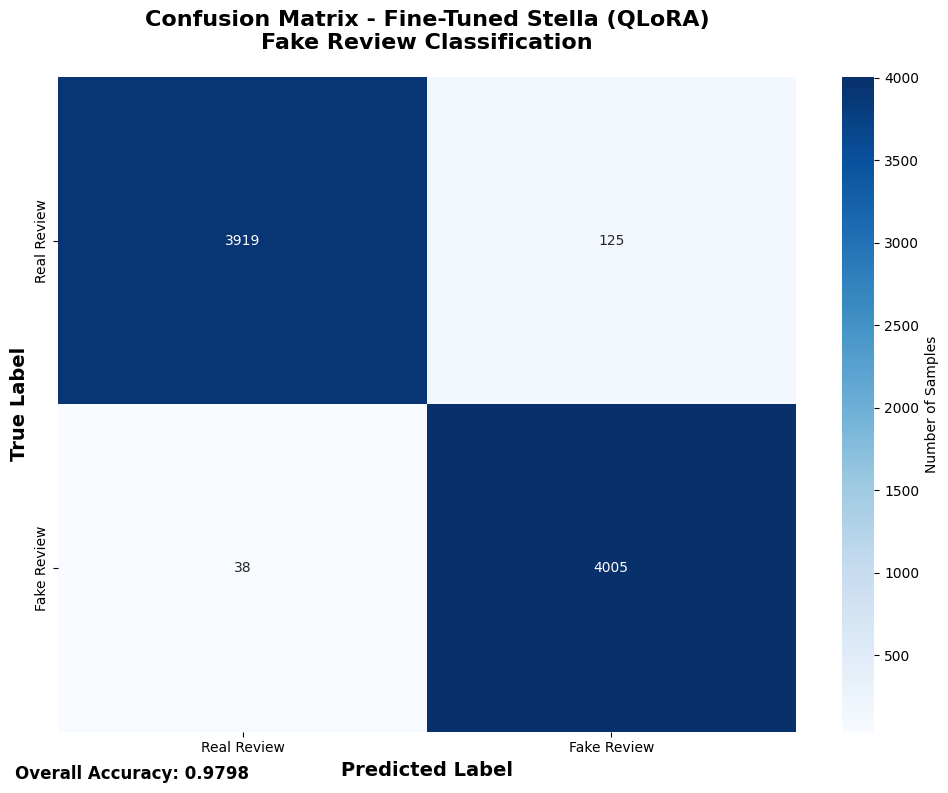


📋 Generating detailed classification report...

📊 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Real Review     0.9904    0.9691    0.9796      4044
 Fake Review     0.9697    0.9906    0.9801      4043

    accuracy                         0.9798      8087
   macro avg     0.9801    0.9798    0.9798      8087
weighted avg     0.9801    0.9798    0.9798      8087


🎯 Creating confusion matrix visualization...
              precision    recall  f1-score   support

 Real Review     0.9904    0.9691    0.9796      4044
 Fake Review     0.9697    0.9906    0.9801      4043

    accuracy                         0.9798      8087
   macro avg     0.9801    0.9798    0.9798      8087
weighted avg     0.9801    0.9798    0.9798      8087


🎯 Creating confusion matrix visualization...


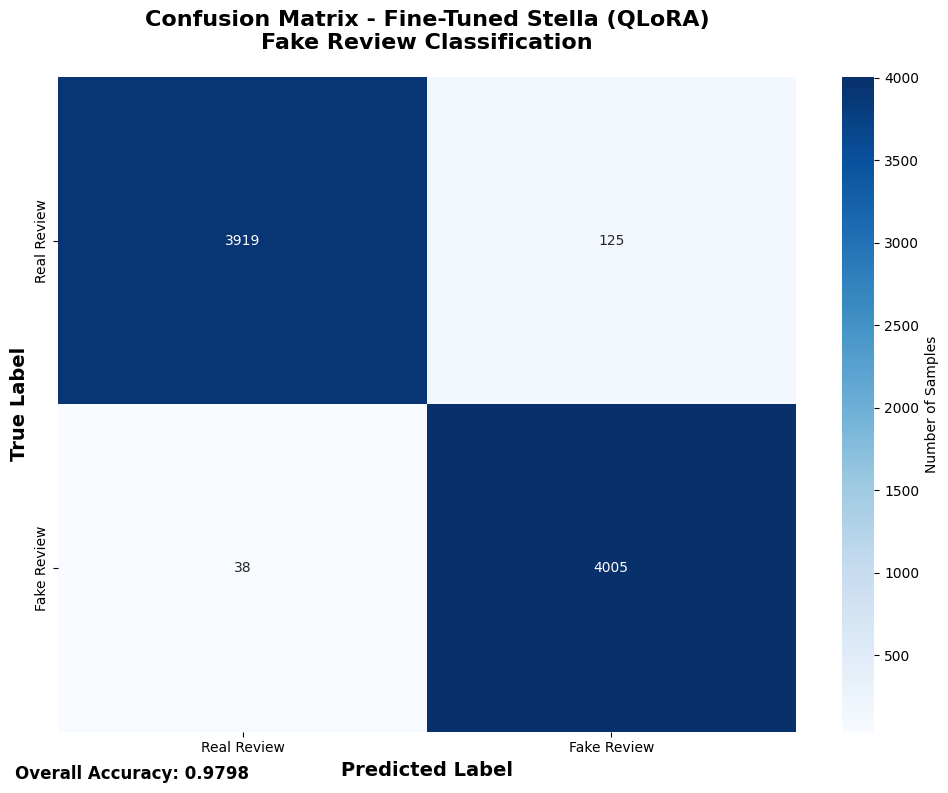


🏆 FINAL PERFORMANCE SUMMARY
🎯 Overall Accuracy:  0.9798 (97.98%)
🎯 Weighted Precision: 0.9801
🎯 Weighted Recall:    0.9798
🎯 Weighted F1-Score:  0.9798
🎯 Overall Accuracy:  0.9798 (97.98%)
🎯 Weighted Precision: 0.9801
🎯 Weighted Recall:    0.9798
🎯 Weighted F1-Score:  0.9798

📊 Per-Class Metrics:

   Real Review:
      Precision: 0.9904
      Recall:    0.9691
      F1-Score:  0.9796
      Support:   4044 samples

   Fake Review:
      Precision: 0.9697
      Recall:    0.9906
      F1-Score:  0.9801
      Support:   4043 samples

✅ EVALUATION COMPLETED SUCCESSFULLY!

📊 Per-Class Metrics:

   Real Review:
      Precision: 0.9904
      Recall:    0.9691
      F1-Score:  0.9796
      Support:   4044 samples

   Fake Review:
      Precision: 0.9697
      Recall:    0.9906
      F1-Score:  0.9801
      Support:   4043 samples

✅ EVALUATION COMPLETED SUCCESSFULLY!


In [15]:
# ==============================================================================
# RESULTS VISUALIZATION
# ==============================================================================
if 'test_results' in locals() and test_results is not None:
    print("\n📋 Generating detailed classification report...")
    
    y_true = test_results['y_true']
    y_pred = test_results['y_pred']
    
    # Classification report
    print("\n📊 DETAILED CLASSIFICATION REPORT")
    print("="*60)
    report = classification_report(
        y_true, y_pred, 
        target_names=["Real Review", "Fake Review"],
        digits=4
    )
    print(report)
    
    # Confusion matrix
    print("\n🎯 Creating confusion matrix visualization...")
    
    # Set up the plot style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=["Real Review", "Fake Review"], 
        yticklabels=["Real Review", "Fake Review"],
        cbar_kws={'label': 'Number of Samples'}
    )
    
    plt.title('Confusion Matrix - Fine-Tuned Stella (QLoRA)\nFake Review Classification', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    
    # Add accuracy annotation
    accuracy = accuracy_score(y_true, y_pred)
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.4f}', 
                fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Performance summary
    print("\n🏆 FINAL PERFORMANCE SUMMARY")
    print("="*50)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    print(f"🎯 Overall Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"🎯 Weighted Precision: {precision:.4f}")
    print(f"🎯 Weighted Recall:    {recall:.4f}")
    print(f"🎯 Weighted F1-Score:  {f1:.4f}")
    
    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(y_true, y_pred)
    
    print(f"\n📊 Per-Class Metrics:")
    for i, class_name in enumerate(["Real Review", "Fake Review"]):
        print(f"\n   {class_name}:")
        print(f"      Precision: {precision_per_class[i]:.4f}")
        print(f"      Recall:    {recall_per_class[i]:.4f}")
        print(f"      F1-Score:  {f1_per_class[i]:.4f}")
        print(f"      Support:   {support[i]} samples")
    
    print("\n" + "="*50)
    print("✅ EVALUATION COMPLETED SUCCESSFULLY!")
    print("="*50)
    
else:
    print("⚠️ No test results available for visualization.")
    print("Please ensure the evaluation step completed successfully.")

## 13. Summary and Next Steps

Final summary of the fine-tuning process and recommendations.

In [16]:
# ==============================================================================
# SUMMARY AND NEXT STEPS
# ==============================================================================
print("\n🎉 QLORA FINE-TUNING SUMMARY")
print("="*60)

if 'test_results' in locals() and test_results is not None:
    print("✅ Fine-tuning completed successfully!")
    print(f"\n📋 Configuration used:")
    print(f"   🤖 Model: {MODEL_NAME}")
    print(f"   🎯 Target modules: {LORA_TARGET_MODULES}")
    print(f"   🔧 LoRA rank: {LORA_R}")
    print(f"   📊 Batch size: {BATCH_SIZE} (effective: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS})")
    print(f"   📚 Learning rate: {LEARNING_RATE}")
    print(f"   🔄 Epochs: {NUM_EPOCHS}")
    
    # Calculate final metrics
    if 'y_true' in test_results and 'y_pred' in test_results:
        final_accuracy = accuracy_score(test_results['y_true'], test_results['y_pred'])
        _, _, final_f1, _ = precision_recall_fscore_support(
            test_results['y_true'], test_results['y_pred'], average='weighted'
        )
        
        print(f"\n🏆 Final Results:")
        print(f"   🎯 Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
        print(f"   🎯 Test F1-Score: {final_f1:.4f}")
    
    print(f"\n💾 Model saved to: {OUTPUT_DIR}")
    
else:
    print("⚠️ Fine-tuning process encountered issues.")
    print("Please review the error messages above and check:")
    print("   - GPU availability and memory")
    print("   - Dataset path and format")
    print("   - Library compatibility")
    print("   - Target module configuration")

print(f"\n🚀 Next Steps:")
print(f"   1. 🔄 You can now load the fine-tuned model for inference")
print(f"   2. 📊 Compare results with other classification methods")
print(f"   3. 🎯 Consider hyperparameter tuning for better performance")
print(f"   4. 📝 Deploy the model for real-world fake review detection")

print(f"\n📖 Model Loading Example:")
print(f"```python")
print(f"from peft import AutoPeftModelForSequenceClassification")
print(f"from transformers import AutoTokenizer")
print(f"")
print(f"# Load the fine-tuned model")
print(f"model = AutoPeftModelForSequenceClassification.from_pretrained('{OUTPUT_DIR}')")
print(f"tokenizer = AutoTokenizer.from_pretrained('{MODEL_NAME}')")
print(f"```")

print("\n" + "="*60)
print("🎯 QLoRA FINE-TUNING NOTEBOOK COMPLETED!")
print("="*60)


🎉 QLORA FINE-TUNING SUMMARY
✅ Fine-tuning completed successfully!

📋 Configuration used:
   🤖 Model: NovaSearch/stella_en_400M_v5
   🎯 Target modules: ['qkv_proj', 'o_proj']
   🔧 LoRA rank: 16
   📊 Batch size: 2 (effective: 16)
   📚 Learning rate: 0.0002
   🔄 Epochs: 3

🏆 Final Results:
   🎯 Test Accuracy: 0.9798 (97.98%)
   🎯 Test F1-Score: 0.9798

💾 Model saved to: ./stella_qlora_finetuned_model

🚀 Next Steps:
   1. 🔄 You can now load the fine-tuned model for inference
   2. 📊 Compare results with other classification methods
   3. 🎯 Consider hyperparameter tuning for better performance
   4. 📝 Deploy the model for real-world fake review detection

📖 Model Loading Example:
```python
from peft import AutoPeftModelForSequenceClassification
from transformers import AutoTokenizer

# Load the fine-tuned model
model = AutoPeftModelForSequenceClassification.from_pretrained('./stella_qlora_finetuned_model')
tokenizer = AutoTokenizer.from_pretrained('NovaSearch/stella_en_400M_v5')
```

🎯 QLo